In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
from analysis_tools_cython import *

In [3]:
# for filename in os.listdir('tests/')[4:5]:
#     data = pd.read_csv(os.path.join('tests/',filename))
#     data = data[['time','injected_dip_flux','quality','flux error']]
#     results, data_arrays = processing(data, f_path =f"TIC{filename.split('_')[-1].split('.csv')[0]}", method='median',make_plots=True)
#     print(results)
#     #plt.scatter(data['time'], data['injected_dip_flux'],s=8)
#     plt.show()

In [4]:
table, lc_info = import_lightcurve('kepler/kplr003542116-2012088054726_llc.fits')

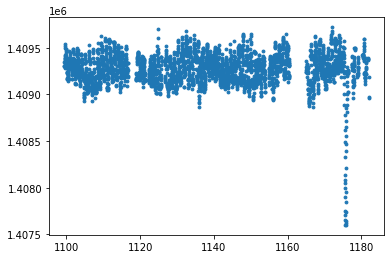

In [5]:
plt.scatter(table['TIME'],table['PDCSAP_FLUX'],s=8)

In [6]:
# table = pd.read_csv('tests/injected_lightcurve_tesslc_79776871.csv')
# table = Table.from_pandas(table)
# table = table[['time','injected_dip_flux','quality','flux error']]

In [7]:
#plt.scatter(table['time'],table['injected_dip_flux'])

In [8]:
time, flux, quality, real, flux_error = clean_data(table)
flux = normalise_flux(flux)
flux_ls = np.copy(flux)
lombscargle_filter(time,flux_ls,real,0.08) 
trend_flux = flux - flux_ls 
flux_ls *= real

In [9]:
len(table)

3242

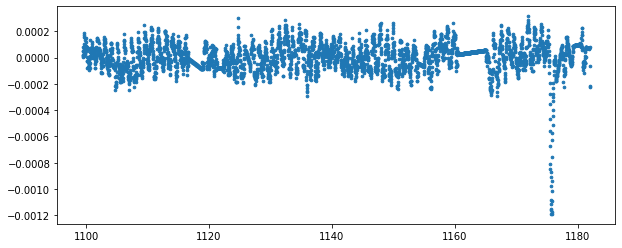

In [10]:
plt.figure(figsize=(10,4))
plt.scatter(time, flux,s=7)

In [11]:
timestep = calculate_timestep(table)
factor = ((1/48)/timestep)
N = len(time)
ones = np.ones(N)

## fourier and Lomb-Scargle
A_mag = np.abs(np.fft.rfft(normalise_flux(flux)))

freq, powers = LombScargle(time,flux).autopower() # think about that one
peak_power = powers.max()

## M-statistic
M_stat = calc_mstatistic(flux)


In [12]:
T1 = test_statistic_array(flux,60 * factor)

m, n = np.unravel_index(
T1.argmin(), T1.shape
)  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
minT = T1[m, n]
#Ts = nonzero(T1[m,n]).std()
minT_time = time[n]
minT_duration = m * timestep
Tm_start = n-math.floor((m-1)/2)
Tm_end = Tm_start + m
Tm_depth = flux[Tm_start:Tm_end].mean() 
Ts = nonzero(T1[m]).std() # only the box width selected. Not RMS of all T-statistic

In [13]:
from scipy.stats import linregress


In [14]:
from scipy.optimize import curve_fit

def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

In [15]:
w = 5
n_m_bg_start =  w/4
n_m_bg_end = 1

if n-w*m >= 0 and n+w*m < len(time):
    t = time[n-w*m:n+w*m] # time
    if (t[-1]-t[0]) / np.median(np.diff(t)) / len(t) > 1.5:
        print(-4,-4,-4)
    t0 = time[n]
    diffs = np.diff(t)
    for i,diff in enumerate(diffs):
        if diff > 0.5 and (t0-t[i])>0 and (t0-t[i])<2:
            print(-5,-5,-5)
    x = flux[n-w*m:n+w*m] # flux
    x_copy = np.copy(x)
    x_original = np.copy(x)
    q = quality[n-w*m:n+w*m]
    #background_level = (sum(x[:m]) + sum(x[(2*w-1)*m:]))/(2*m)
    ## nmbgstart to be smaller over cutout width
    bg_l1 = np.mean(x[:int(n_m_bg_start*m)])
    bg_t1 = np.mean(t[:int(n_m_bg_start*m)])
    bg_l2 = np.mean(x[int((2*w-n_m_bg_end))*m:])
    bg_t2 = np.mean(t[int((2*w-n_m_bg_end))*m:])
    grad = (bg_l2-bg_l1)/(bg_t2-bg_t1)

    background_level = bg_l1 + grad * (t - bg_t1)
    #x -= background_level
#     #background_level = list(reversed(background_level)

    try:
        params1, pcov1 = single_gaussian_curve_fit(t,-x)
        params2, pcov2 = comet_curve_fit(t,-x)
    except:
        print(-3,-3,-3)

    fit1 = -gauss(t,*params1)
    fit2 = -comet_curve(t,*params2)
    depth = fit2.min()

#     scores = [score_fit(x,fit) for fit in [fit1,fit2]]
#     if scores[1] > 0:
#         shape = scores[0]/scores[1], params2[2], params2[3], [t,x,q,fit1,fit2,background_level,pcov1,pcov2]
#     else:
#         print(-1,-1,-1)
# else:
#     print(-2,-2,-2)
    
    ## eg: nw/4 

In [16]:
np.mean(x[:int(n_m_bg_start*m)])

6.340714298697709e-05

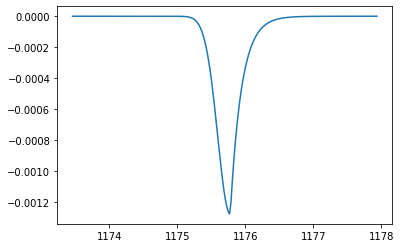

In [17]:
plt.plot(t, fit2)

In [18]:
fit2.min()

-0.0012767108172397027

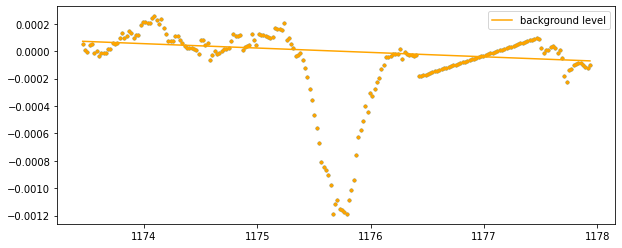

In [19]:
plt.figure(figsize=(10,4))
plt.scatter(t, x_original,s=8)
plt.scatter(t, x,s=8,color='orange')
#plt.scatter(t,x_copy,s=8,color='black')
plt.plot(t,background_level,color='orange',label='background level')
#plt.plot(t,f(t,*popt),color='black',label='curve fit background level')
plt.legend()

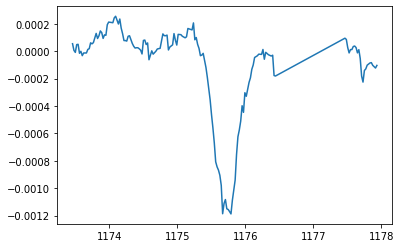

In [20]:
plt.plot(t,x)

In [21]:
grad = (x[-1] - x[0])/(t[-1] - t[0])
background = bg_l1 + grad * (t - bg_t1)

In [22]:
n_m_bg_end2 = w/8 
tbg_l1 = np.mean(x[:int(n_m_bg_start*m)])
tbg_t1 = np.mean(t[:int(n_m_bg_start*m)])
tbg_l2 = np.mean(x[int((2*w-n_m_bg_end2))*m:])
tbg_t2 = np.mean(t[int((2*w-n_m_bg_end2))*m:])

In [23]:
plt.plot(t,x)
plt.plot(t,background_level)
plt.plot(bg_t1,bg_l1,marker='o',color='orange')
plt.plot(bg_t2,bg_l2,marker='o',color='orange')
plt.plot(tbg_t1,tbg_l1,marker='o',color='black')
plt.plot(tbg_t2,tbg_l2,marker='o',color='black')

Error in callback <function flush_figures at 0x7f81469780e0> (for post_execute):


KeyboardInterrupt: 

---

In [24]:
import random
import glob

In [25]:
cd /storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104/

/storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104


In [26]:
path = '/storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104/'

In [27]:
randomFile = random.sample(glob.glob[f for f in list(os.scandir(path + '/*.pkl'))],10)

SyntaxError: invalid syntax (<ipython-input-27-25339165a6a1>, line 1)

In [ ]:
randomFile

---

## Creating a function to return TESS lightcurve of any target/TIC ID

In [ ]:
import lightkurve as lk
import eleanor

In [ ]:
lc = lk.search_lightcurve("HD172555")
lc

In [ ]:
print(len(lc))

In [ ]:
eleanor.Update(66)

In [ ]:
eleanor.Source(tic="464405850")

In [ ]:
def search_lightcurve(tessid,pipeline):
    """
    pipeline options: "SPOC", "TESS-SPOC", "QLP", "eleanor", "TASOC"
    """
    try:
        lc = lk.search_lightcurve(tessid)
        print("lightcurves available for this target:", lc)
    except 

---

In [ ]:
cd ..

In [ ]:
from analysis_tools_cython import *
from injection_tools import inject_lightcurve
import numpy as np

In [ ]:
data, lc_info = import_XRPlightcurve('/storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104/2_min_cadence_targets/tesslc_270577175.pkl',sector=6)

In [ ]:
data['injected_flux'] = inject_lightcurve(data['time'],data['corrected flux'],10 ** np.random.uniform(-4, -2, 1)[0],1485)
data = data[['time','injected_flux','quality','flux error']]

In [ ]:
plt.plot(data['time'], data['injected_flux'])

In [ ]:
data, results = processing(data, f_path = '.' , method = 'median', make_plots = True, lc_info= lc_info)

---

In [ ]:
cd /storage/astro2/phrdhx/tesslcs/

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('sector6lookup.csv')

In [ ]:
data.head()

In [ ]:
tmag67 = data.loc[(data.Magnitude >= 6) & (data.Magnitude <= 7)]

In [ ]:
tmag67 = tmag67[tmag67.Filename.str.contains('tmag_6_7')]

---

In [ ]:
cd /storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104/tesslcs_tmag_6_7/

In [ ]:
import glob
import os
import pandas as pd

In [ ]:
a = glob.glob('*.pkl') 

---

In [ ]:
path = 'tesslcs_sector_6_104/tesslcs_tmag_6_7/'

In [ ]:
b = []
for i in a:
    b.append(os.path.join(path,i))

In [ ]:
a = pd.DataFrame(b,columns=['file'])
a

In [ ]:
no_ids = tmag67[tmag67.Filename.isin(a.file)]

In [ ]:
no_ids[no_ids.Filename == 'tesslcs_sector_6_104/tesslcs_tmag_6_7/tesslc_156734223.pkl']

In [ ]:
tmag67[tmag67.Filename.isin(a.file)].to_csv('sector6lookupv2.csv',index=False)

In [ ]:
lost = tmag67[tmag67.Filename.isin(a.file) == False]

In [ ]:
cd /home/astro/phrdhx/automated_exocomet_hunt/

In [ ]:
lost.Filename.to_csv('lost_ids.txt',index=False)

In [ ]:
rm lost_ids.txt

---

### Injection Recovery Script

In [ ]:
from analysis_tools_cython import *
import random

In [ ]:
data, lc_info = import_XRPlightcurve('/storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104/tesslcs_tmag_6_7/tesslc_10000516001.pkl',sector=6,return_type='pandas')

In [ ]:
depth = 10 ** np.random.uniform(-4, -2, 1)[0]
time_range = data["time"][
    data["time"].between(
        data["time"].min() + 1, data["time"].max() - 1, inclusive=False
    )
].reset_index(
    drop=True
)  # resets index so consistency is kept when working with indices
injected_time_index, injected_time = random.choice(list(enumerate(time_range)))

## comet model
data["injected_dip_flux"] = data["corrected flux"] * (
    1
    - comet_curve(
        data["time"], depth, injected_time, 3.02715600e-01, 3.40346173e-01
    )
)

data = Table.from_pandas(data)
data = data[["time", "injected_dip_flux", "quality", "flux error"]]
results, data_arrays = processing(data, path, lc_info, method="median")
# try:
#     os.makedirs("injection_recovery_data_arrays/")
# except FileExistsError:
#     pass
# try:
#     np.savez(
#         f"injection_recovery_data_arrays/{i}.npz",
#         time=data_arrays[0],
#         flux=data_arrays[1],
#         trend_flux=data_arrays[2],
#         quality=data_arrays[3],
#     )
# except:
#     np.savez(
#         f"injection_recovery_data_arrays/{i}.npz",
#         time=data_arrays[0],
#         flux=data_arrays[1],
#         quality=data_arrays[2],
#     )
# results = results.split()
# recovered_time = float(results[3])
# new_depth = float(results[8])
# recovered_depth.append(float(results[8]))
# results_for_binning.append(results)

# data = data.to_pandas()
# recovered_range = data.time[
#     data.time.loc[data.time == injected_time].index[0]
#     - 5 : data.time.loc[data.time == injected_time].index[0]
#     + 5
# ].reset_index(drop=True)

# try:
#     percentage_change = (
#         (abs(new_depth) - depth)/depth) * 100 # 0-depth to consider normalisation
# except ZeroDivisionError:
#     percentage_change = 0

# if (
#     recovered_range.values[0] <= recovered_time <= recovered_range.values[-1]
# ) & (abs(percentage_change) <= 50):
#     recovered = 1
#     recovered_or_not.append(recovered)
# else:
#     recovered = 0
#     recovered_or_not.append(recovered)

# df = pd.DataFrame(results_for_binning)
# df.insert(0, "file", filename)
# df["recovered"] = recovered_or_not
# df["magnitude"] = mags
# df["injected_depths"] = depths

# cols = [
# "file",
# "signal",
# "snr",
# "time",
# "asym_score",
# "width1",
# "width2",
# "duration",
# "depth",
# "peak_lspower",
# "mstat",
# "transit_prob",
# "recovered",
# "mag",
# "injected_depth",
# ]

# df.columns = cols
# df.depth = [float(i) for i in df.depth]

---

In [ ]:
import pandas as pd

In [ ]:
lookup = pd.read_csv(f"/storage/astro2/phrdhx/tesslcs/sector6lookup.csv")

In [ ]:
def new_select_lightcurves(mag_lower,mag_higher):
    return lookup.Filename[(lookup.Magnitude >= mag_lower) & (lookup.Magnitude <= mag_higher)].values

In [ ]:
len(new_select_lightcurves(5,6))

In [ ]:
lookup.Filename.str.split('/')[1]

In [ ]:
import glob

In [ ]:
type(glob.glob("*.py"))

---

# remaking `calc_shape`

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
from analysis_tools_cython import *

In [4]:
table, lc_info = import_XRPlightcurve("betapic/xrp/tesslcs_sector_6_104_2_min_cadence_targets_tesslc_270577175.pkl", sector=6)
table, lc_info = import_lightcurve('betapic/fits/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits')

In [7]:
flat_flux, trend_flux = smoothing(table,method='median')

In [8]:
a = Table()
a['time'] = table[table.colnames[0]]
a['flux'] = flat_flux - np.ones(len(flat_flux))
a['quality'] = table[table.colnames[2]]
a['flux_error'] = table[table.colnames[3]]
#table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
t, flux, quality, real, flux_error = clean_data(a)

In [9]:
timestep = calculate_timestep(table)
factor = ((1/48)/timestep)

N = len(t)
ones = np.ones(N)
T1 = test_statistic_array(flux,60 * factor)

m, n = np.unravel_index(
T1.argmin(), T1.shape
)  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
minT = T1[m, n]
#Ts = nonzero(T1[m,n]).std()
minT_time = t[n]
minT_duration = m * timestep
Tm_start = n-math.floor((m-1)/2)
Tm_end = Tm_start + m
Tm_depth = flux[Tm_start:Tm_end].mean() 
Ts = nonzero(T1[m]).std() # only the box width selected. Not RMS of all T-statistic

In [10]:
n_m_bg_start = m/4
n_m_bg_end = m/8

In [11]:
import math

In [15]:
def calc_shape(m,n,time,quality,flux,flux_error,cutout_half_width=3):
    """Fit both symmetric and comet-like transit profiles and compare fit.
    Returns:
    (1) Asymmetry: ratio of (errors squared)
    Possible errors and return values:
    -1 : Divide by zero as comet profile is exact fit
    -2 : Too close to end of light curve to fit profile
    -3 : Unable to fit model (e.g. timeout)
    -4 : Too much empty space in overall light curve or near dip
    -5 : Gap within 2 days before dip

    (2,3) Widths of comet curve fit segments.
    info: t, x, q, fit1 and fit2 are the transit shape elements 

    """
    w = cutout_half_width
    ## how many transit widths to take the general linear trend from. start is 1/4 length of cutout from beginning, end is 1 from end.
    n_m_bg_start = w/4
    n_m_bg_end = w/8
    if n-w*m >= 0 and n+w*m < len(time):
        t = time[n-w*m:n+w*m] # time
        if (t[-1]-t[0]) / np.median(np.diff(t)) / len(t) > 1.5:
            return -4,-4,-4, 0, 0
        t0 = time[n]
        diffs = np.diff(t)
        for i,diff in enumerate(diffs):
            if diff > 0.5 and (t0-t[i])>0 and (t0-t[i])<2:
                return -5,-5,-5, 0, 0
        x = flux[n-w*m:n+w*m] # flux
        q = quality[n-w*m:n+w*m]
        fe = flux_error[n-w*m:n+w*m]
        # background_level = (sum(x[:m]) + sum(x[(2*w-1)*m:]))/(2*m)
        bg_l1 = np.mean(x[:int(n_m_bg_start*m)])
        bg_t1 = np.mean(t[:int(n_m_bg_start*m)])
        bg_l2 = np.mean(x[(2*w-int(n_m_bg_end*m)):])
        bg_t2 = np.mean(t[(2*w-int(n_m_bg_end*m)):])
        grad = (bg_l2-bg_l1)/(bg_t2-bg_t1)
        print(len(time))
        print(len(t))
        background_level = bg_l1 + grad * (t - bg_t1)
        x -= background_level

        try:
            params1, pcov1 = single_gaussian_curve_fit(t,-x)
            params2, pcov2 = comet_curve_fit(t,-x)
        except:
            return -3,-3,-3, 0, 0

        fit1 = -gauss(t,*params1)
        fit2 = -comet_curve(t,*params2)
        depth = fit2.min()

        scores = [score_fit(x,fit) for fit in [fit1,fit2]]
        if scores[1] > 0:
            return scores[0]/scores[1], params2[2], params2[3], depth, [t,x,q,fe,fit1,fit2,background_level]
        else:

            return -1,-1,-1, 0, 0 
    else:     

        return -2,-2,-2, 0, 0


In [16]:
scores, param1, param2, depth, info = calc_shape(m,n,t,quality,flux,flux_error)

1044
246


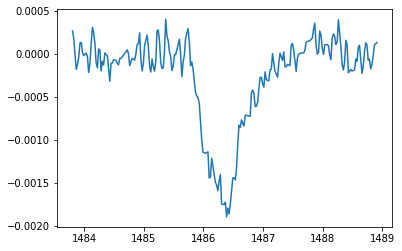

In [17]:
plt.plot(info[0],info[1])

In [18]:
from scipy.stats import skew

In [20]:
skew(-info[1])

1.6799923533346168

---

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import random
from analysis_tools_cython import *
import pandas

In [25]:
data, lc_info = import_XRPlightcurve(
"betapic/xrp/tesslcs_sector_6_104_2_min_cadence_targets_tesslc_270577175.pkl", sector=6, return_type="pandas", drop_bad_points=True)

depth = 10 ** np.random.uniform(-5, -0.5, 1)[0]
time_range = data["time"][
data["time"].between(
    data["time"].min() + 1, data["time"].max() - 1, inclusive=False
)
].reset_index(
drop=True
)  # resets index so consistency is kept when working with indices
_ , injected_time = random.choice(list(enumerate(time_range)))

## comet model
#comet = 1 - comet_curve(data["time"], depth, injected_time, 3.02715600e-01, 3.40346173e-01)
data["injected_dip_flux"] = data['corrected flux']*(1-comet_curve(data['time'],depth, injected_time, 3.02715600e-01, 3.40346173e-01))

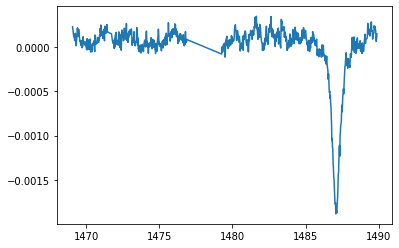

In [26]:
plt.plot(data['time'],normalise_flux(data['injected_dip_flux']))

In [27]:
time_range_cutout = data.time[data.time.loc[data.time == injected_time].index[0]- 50 : data.time.loc[data.time == injected_time].index[0]+ 50]

In [28]:
flux_range_cutout = data['injected_dip_flux'][data['injected_dip_flux'].loc[data.time == injected_time].index[0] - 50 : data['injected_dip_flux'].loc[data.time == injected_time].index[0]+ 50]

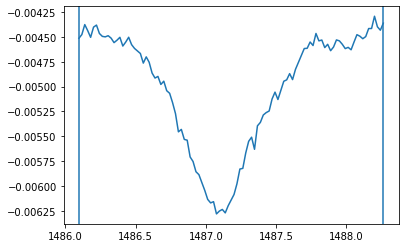

In [32]:
#plt.plot(data['time'],normalise_flux(data['injected_dip_flux']))
plt.plot(time_range_cutout,normalise_flux(flux_range_cutout)-0.005)
plt.axvline(x=time_range_cutout.values[0])
plt.axvline(x=time_range_cutout.values[-1])

In [30]:
from scipy.stats import skew

In [42]:
skew(-flux_range_cutout)

0.8355066643415856

In [43]:
flux_range_cutout

636    347035.283212
637    347048.201884
638    347083.014045
639    347061.940441
640    347038.630079
           ...      
731    347069.421916
732    347112.118685
733    347075.337477
734    347063.439955
735    347087.968853
Name: injected_dip_flux, Length: 100, dtype: float64

In [36]:
params1, pcov1 = single_gaussian_curve_fit(time_range_cutout.values,normalise_flux(flux_range_cutout.values))
params2, pcov2 = comet_curve_fit(time_range_cutout.values,normalise_flux(flux_range_cutout.values))

In [37]:
fit1 = -gauss(time_range_cutout.values,*params1)
fit2 = -comet_curve(time_range_cutout.values,*params2)
scores = [score_fit(time_range_cutout.values,fit) for fit in [fit1,fit2]]

In [38]:
scores[0]/scores[1]

0.9999999960520889

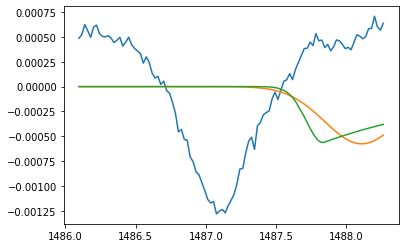

In [39]:
plt.plot(time_range_cutout.values,normalise_flux(flux_range_cutout.values))
plt.plot(time_range_cutout.values,fit1)
plt.plot(time_range_cutout.values,fit2)

In [110]:
data = data[["time", "injected_dip_flux", "quality", "flux error"]]
data = Table.from_pandas(data)


In [32]:
results, arrays = processing(data,".",lc_info,method=None,noiseless=False)

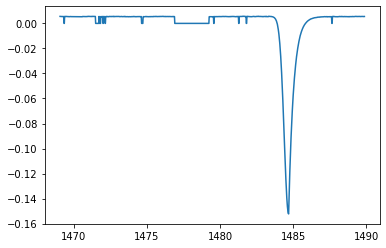

In [33]:
plt.plot(arrays[0],arrays[1])

---

## Would LS periodogram work on 2-min lightcurves?

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import lightkurve as lk
from lightkurve import periodogram
from analysis_tools_cython import *

In [6]:
lc = lk.search_lightcurve("Beta Pictoris",exptime=120)[5].download()

In [12]:
periodogram.LombScarglePeriodogram.from_lightcurve(lc)

LombScarglePeriodogram(ID: TIC 270577175)

---

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
from analysis_tools_cython import *

In [3]:
lc, lc_info = import_lightcurve('betapic/fits/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits')

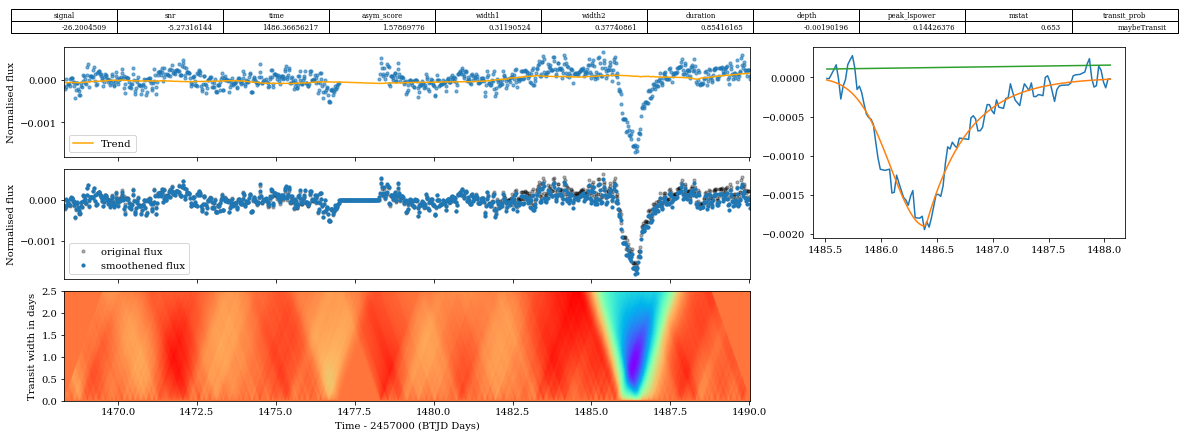

In [4]:
results, arrays = processing(lc,'.',lc_info,method='median',make_plots=True)

In [5]:
import lightkurve as lk

In [33]:
lk.search_lightcurve("toi-849")

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 03,2018,TESS-SPOC,1800,33595516,0.0
1,TESS Sector 03,2018,QLP,1800,33595516,0.0
2,TESS Sector 03,2018,GSFC-ELEANOR-LITE,1800,33595516,0.0
3,TESS Sector 03,2018,TASOC,1800,33595516,0.0
4,TESS Sector 03,2018,TASOC,1800,33595516,0.0


In [38]:
lc = lk.search_lightcurve("toi-849")[1].download()

In [39]:
lc

time,flux,flux_err,cadenceno,sap_flux,kspsap_flux,kspsap_flux_err,quality,orbitid,sap_x,sap_y,sap_bkg,sap_bkg_err,kspsap_flux_sml,kspsap_flux_lag
,,,,,,,,,pix,pix,,,,
object,float32,float32,int32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32
1381.7237227732276,1.0125555992126465,0.0006677225464954972,7404,1.0125556,0.99910796,0.00066772255,4096,13,1761.1171875,1448.8790283203125,1587.75,2943.37,0.9996215,0.998436
1381.7445566076328,1.0140401124954224,0.0006677225464954972,7405,1.0140401,1.0007513,0.00066772255,4096,13,1761.110595703125,1448.8800048828125,958.71,3224.89,1.0002232,1.0014011
1381.7653904428967,1.0139192342758179,0.0006677225464954972,7406,1.0139192,1.0008981,0.00066772255,4096,13,1761.1119384765625,1448.88330078125,1081.55,3153.97,1.0007293,1.0011646
1381.786224278994,1.01199471950531,0.0006677225464954972,7407,1.0119947,0.99934405,0.00066772255,4096,13,1761.112548828125,1448.8843994140625,1196.21,2914.88,0.99975055,0.9993362
1381.8070581158966,1.0126794576644897,0.0006677225464954972,7408,1.0126795,1.0004367,0.00066772255,4096,13,1761.1138916015625,1448.8851318359375,811.14,3323.34,1.0002099,1.0005852
1381.8278919535628,1.011381983757019,0.0006677225464954972,7409,1.011382,0.9996329,0.00066772255,4096,13,1761.116943359375,1448.8863525390625,997.58,2747.84,0.99997187,0.9994617
1381.848725791978,1.010962724685669,0.0006677225464954972,7410,1.0109627,0.9997497,0.00066772255,4096,13,1761.1173095703125,1448.8883056640625,1021.47,2675.21,0.9999271,1.0001388
1381.8695596310934,1.011389136314392,0.0006677225464954972,7411,1.0113891,1.0007478,0.00066772255,4096,13,1761.11865234375,1448.887939453125,1092.75,2387.49,1.0004648,1.0009245


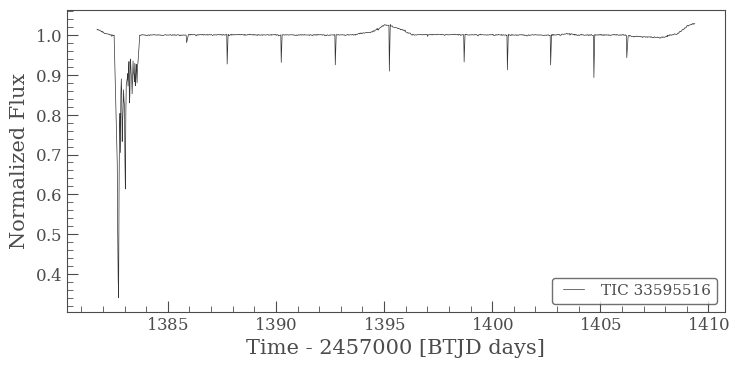

In [40]:
lc.plot()

In [22]:
time = lc.time.value
flux = lc.pdcsap_flux.value
quality = lc.quality.value
flux_err = lc.flux_err.value

In [23]:
a = Table()
a['time'] = time
a['flux'] = flux
#a['flux'] = flat_flux - np.ones(len(flat_flux))
a['quality'] = quality
a['flux_error'] = flux_err

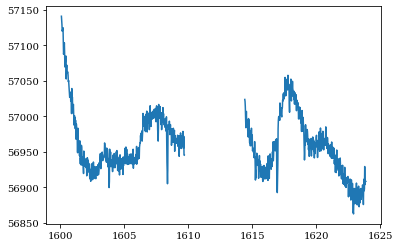

In [41]:
plt.plot(a['time'],a['flux'])